In [1]:
from psaw import PushshiftAPI
import praw
from prawcore import Forbidden
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

from scipy import stats

from pymongo import MongoClient, errors
from bson.json_util import loads, dumps
from bson.objectid import ObjectId

from datetime import datetime as dt

import boto3

import time

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, roc_curve, auc

from imblearn.ensemble import BalancedRandomForestClassifier

from scipy import interp

import string

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
porter = PorterStemmer()
wordnet = WordNetLemmatizer()

In [4]:
client = MongoClient('localhost', 27017)
db = client['cap2']
table = db['first_and_last']

In [5]:
db.list_collection_names()

['submission', 'first_and_last', 'comment']

In [6]:
# count number of documents per collection
for coll in db.list_collection_names():
    print(f'{coll:14}: {db[coll].count_documents({}):6}')

submission    :  14523
first_and_last:    952
comment       : 230853


## Load the data from mongo

In [7]:
query = {}
fields = { '_id': 0 }
# docs is about 1.3 GB in RAM
docs = list(db['comment'].find( query, fields ))

In [8]:
# comms is about 100 MB in RAM
comms = pd.DataFrame(docs)

In [9]:
comms.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230853 entries, 0 to 230852
Data columns (total 71 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   author                           6704 non-null    object 
 1   author_created_utc               6597 non-null    float64
 2   author_flair_css_class           57434 non-null   object 
 3   author_flair_text                58619 non-null   object 
 4   author_fullname                  201891 non-null  object 
 5   body                             230853 non-null  object 
 6   controversiality                 230219 non-null  float64
 7   created_utc                      230853 non-null  float64
 8   distinguished                    380 non-null     object 
 9   gilded                           230215 non-null  float64
 10  id                               230853 non-null  object 
 11  link_id                          230853 non-null  object 
 12  ne

## NLP

In [49]:
orig_stopwords_ = set("a,able,about,across,after,all,almost,also,am,among,an,and,any,\
are,as,at,be,because,been,but,by,can,could,dear,did,do,does,either,\
else,ever,every,for,from,get,got,had,has,have,he,her,hers,him,his,\
how,however,i,if,in,into,is,it,its,just,least,let,like,likely,may,\
me,might,most,must,my,neither,no,of,off,often,on,only,or,other,our,\
own,rather,said,say,says,she,should,since,so,some,than,that,the,their,\
them,then,there,these,they,this,tis,to,too,twas,us,wants,was,we,were,\
what,when,where,which,while,who,whom,why,will,with,would,yet,you,your,u,s".split(','))

# new stopwords after first run through
# sws_to_add_brf1 = 'thanks,op,tie,deleted,game,crypto,invest,\
# edit,platform,play,giveaway,ok,yeah,blockchain,enter,remove,\
# m,token,awesome,ethereum,exchange,steam,dude'.split(',')

# stopwords_ = set(list(orig_stopwords_) + sws_to_add_brf1)

punctuation_ = set(string.punctuation + '’' + '“')

def rm_punctuation(a_string):
    table = str.maketrans('', '', ''.join(punctuation_))
    return a_string.translate(table)
        
def tokens_lower(tokens):
    return [word.lower() for word in tokens]

def filter_tokens(tokens):
#     for w in sent: print(w)
#     if w == "’": print("this is ': " + w)
    return [w for w in tokens if not w in stopwords_]

def stem_tokens(ntlk_stem_obj, tokens):
    # visualize what stemming and lemmitization does!
    # str(porter.__class__) = "<class 'nltk.stem.porter.PorterStemmer'>"
#     name = str(ntlk_stem_lemm_obj.__class__).split("'")[1].split('.')[-1]
#     count_ident = 0
#     count_alter = 0
    return [ntlk_stem_obj.stem(tok) for tok in tokens]
#     elif ''
# for tok in tokens:
#         return ntlk_stem_lemm_obj.stem(tok)
#         if tok == stem_lemm_f_l_tok:
#             count_ident += 1
#         else:
#             print(tok, stem_lemm_f_l_tok)
#             count_alter += 1
#     print('{}:\nNumber of unchanged words: {}\nchanged words: {}\n'.format(name, count_ident, count_alter))

def lemm_tokens(ntlk_lemm_obj, tokens):
    return [ntlk_lemm_obj.lemmatize(tok) for tok in tokens]

In [50]:
def nlp_pre_proc_doc(input_string, stemming=False):
    '''
    given document:
        tokenizes the document
        sets tokens to lower case
        filters punctuation and stop words from tokens
        returns porter, snowball, and wordnet stem/lemm tokens
    '''
    no_punct_string = rm_punctuation(input_string)
    tokens = word_tokenize(no_punct_string)
    lo_tokens = tokens_lower(tokens)
    f_lo_tokens = filter_tokens(lo_tokens)
    if stemming:
        s_f_lo_tokens = stem_tokens(porter, f_lo_tokens)
        le_s_f_lo_tokens = lemm_tokens(wordnet, s_f_lo_tokens)
        return ' '.join(le_s_f_lo_tokens)
    else:
        le_f_lo_tokens = lemm_tokens(wordnet, f_lo_tokens)
        return ' '.join(le_f_lo_tokens)

In [51]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [52]:
# this takes a few minutes, and uses about 100 MB of RAM
corpus = [nlp_pre_proc_doc(d) for d in comms['body']]

## Train classifier(s)

In [53]:
# keep a dictionary of trained classifiers for comparison
clfs = {}

### random forest
Spoke with Dan. He suggests using a random forest classifier on the tfidf vectors first to see the individual words that associate with the labels. Cool

need to add the class labels to the comment dataframe, k
do I have the author information from praw-only comments? 
If so, compare with set of troll author names

In [54]:
# assign the label, 'troll?'' to each comment
troll_comment_ids_set = set(comms[~comms['author'].isna()]['id'])
comms['troll?'] = [int(mybool) for mybool in [
                    commid in troll_comment_ids_set for commid in comms['id']
                    ]]
y = comms['troll?']
num_troll_comments = np.sum(y)
num_troll_comments

6704

Next, do a train test split

In [55]:
X_train_corp, X_test_corp, y_train, y_test = train_test_split(
        corpus, comms['troll?'], test_size=0.2, random_state=30, shuffle=True)

In [56]:
# still using max features = 5000
n_features = 5000

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, ngram_range=(1, 2),
                                   max_features=n_features,
                                   stop_words='english')

In [57]:
t0 = time.time()
# X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_corp)
print("done in %0.3fs." % (time.time() - t0))

done in 9.099s.


In [58]:
X_test_tfidf = tfidf_vectorizer.transform(X_test_corp)

In [59]:
X_train = X_train_tfidf.toarray()
X_test = X_test_tfidf.toarray()

In [60]:
# fit the model
# at first I did 100 estimators, but 100*25 is only 2500 
#  whereas we have 5000 features in tfidf. Increase to 400
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30}

In [61]:
brf = BalancedRandomForestClassifier(**model_param, )
brf.fit(X_train, y_train)

/home/ubuntu/miniconda3/envs/ipy/lib/python3.8/site-packages/imblearn/ensemble/_forest.py:591: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


BalancedRandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                               criterion='gini', max_depth=5, max_features=25,
                               max_leaf_nodes=None, max_samples=None,
                               min_impurity_decrease=0.0, min_samples_leaf=2,
                               min_samples_split=2,
                               min_weight_fraction_leaf=0.0, n_estimators=400,
                               n_jobs=-1, oob_score=True, random_state=30,
                               replacement=False, sampling_strategy='auto',
                               verbose=0, warm_start=False)

In [62]:
# include the model for comparisons
clfs['Balanced_RF'] = brf

In [63]:
# measure accuracy
print("\n R^2 score:", brf.score(X_test, y_test))
print(f'\n Out of bag score: {brf.oob_score_}')
y_predict = brf.predict(X_test)
np.sum(y_predict)


 R^2 score: 0.7687292889476078

 Out of bag score: 0.6723243675479097


10579

In [64]:
print("\n precision:", precision_score(y_test, y_predict))
print("    recall:", recall_score(y_test, y_predict))


 precision: 0.05841761981283675
    recall: 0.46292134831460674


#### look at the probabilities with an ROC

In [65]:
def plot_roc_nofit(ax, X_test, y_test, clf, clf_name, **kwargs):
    y_prob = np.zeros((len(y_test),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    # Predict probabilities, not classes
    y_prob = clf.predict_proba(X_test)
    fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    if len(ax.lines) == 0:
        plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    ax.plot(fpr, tpr, lw=1, label='%s (area = %0.2f)' % (clf_name, roc_auc))
    mean_tpr /= 1
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
#     plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right", )

<ipython-input-65-4bcd29495c04>:9: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


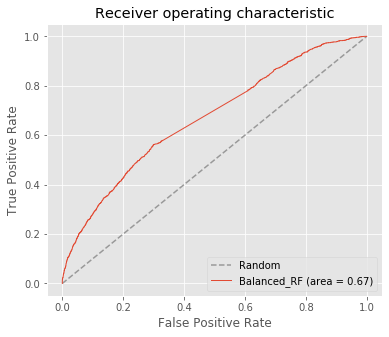

In [66]:
fig, ax = plt.subplots(1, figsize=(6, 5))
for label, clf in clfs.items():
    plot_roc_nofit(ax, X_test, y_test, clf, label)

In [69]:
def plot_roc(X, y, clf, plot_name, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    n_splits=5
    kf = KFold(n_splits=n_splits, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
#         clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='%s fold %d (area = %0.2f)' % (plot_name, i, roc_auc))
    mean_tpr /= n_splits
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

Use the included `plot_roc` function to visualize the roc curve of each model


<ipython-input-69-17f9d4f093c5>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-69-17f9d4f093c5>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-69-17f9d4f093c5>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-69-17f9d4f093c5>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)
<ipython-input-69-17f9d4f093c5>:18: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(mean_fpr, fpr, tpr)


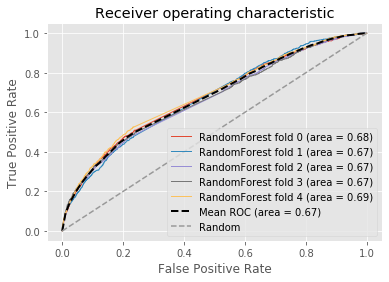

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

# see `class_weight` parameter to treat unbalanced classes
# https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7
model_param = {'n_estimators': 400,
                   'max_depth': 5,
                   'max_features': 25,
                   'oob_score': True,
                   'n_jobs': -1,
                   'random_state': 30,
                   'class_weight': 'balanced_subsample'
              }

# mini_X_train.shape, mini_y_train.shape

cv_rf = RandomForestClassifier(**model_param)

print("Use the included `plot_roc` function to visualize the roc curve of each model")
plot_roc(X_train, np.array(y_train), cv_rf, 'RandomForest')

## model inspection

#### which features are important?


In [67]:
#Use sklearn's model to get the feature importances
feature_importances = np.argsort(brf.feature_importances_)
feature_names = np.array(tfidf_vectorizer.get_feature_names())
print("\n: top fifty:", list(feature_names[feature_importances[-1:-51:-1]]))
## top five: ['Day Mins', 'CustServ Calls', 'Day Charge', "Int'l Plan", 'Eve Mins']
## (will vary a little)


: top fifty: ['game', 'removed', 'gt', 'police', 'news', 'project', 'agree', 'played', 'think', 'bitcoin', 'trump', 'hahaha', 'iota', 'luck', 'state', 'doing', 'sorry', 'win', 'interesting', 'invested', 'fucking', 'black', 'cop', 'token', 'useful', 'potential', 'read', 'social', 'service', 'tie', 'hillary', 'promising', 'true', 'police state', 'right', 'slave', 'salt', 'xrp', 'example', 'platform', 'ill', 'ayy', 'try', 'price', 'murica', 'innocent', 'story', 'good luck', 'matter', 'money']


In [29]:
mask = np.array(['gt' in doc for doc in corpus])
np.array(corpus)[mask]

array(['oy now there nice quote out context gtone thought even more necessary limit population property limit fixed calculating chance mortality child sterility married person neglect subject existing state common neverfailing cause poverty citizen poverty parent revolution crime sound big calling take care decadent under class more fixing up cheap booze ciggies mate',
       'gt incomprehensible speaking incomprehensible let talk youre putting word mouth youve agreed scientific revolution originated christian thought youve nothing unless enjoy watching yourself post bunch 888 aka youre redditor',
       'gt reading comment youre reading epic devastation saving face calling name thats real story',
       ..., 'live tv httpwwwvgtvnoid55507',
       'different use fish here fishprompt git function function fishgitinworkingtree true git revparse isinsideworktree devnull echo false end function fishgitdirty not git diff noextdiff quiet exitcode devnull not git diffindex cached quiet head d

In [30]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

1488reasons ... troll?: 1
Oy now there's a nice quote out of context:

&gt;One would have thought that it was even more necessary to limit population than property; and that the limit should be fixed by calculating the chances of mortality in the children, and of sterility in married persons. The neglect of this subject, which in existing states is so common, is a never-failing cause of poverty among the citizens; and poverty is the parent of revolution and crime. 

Sounds like big A is calling on us to take care of the decadent under classes more than fixing them up with cheap booze and ciggies mate
 ------------ 

1488reasons ... troll?: 1
&gt; incomprehensible 

Speaking of incomprehensible, let's talk about why you're putting words in my mouth. If you've agreed that the scientific revolution originated in Christian thought, you've got nothing else to say to me unless you just enjoy watching yourself post a bunch of 888 (aka you're a redditor)
 ------------ 

1488reasons ... troll?:

#### Trolls like to include quotes in their replies, putting the `&gt;` at the beginning of lines in their comments

In [31]:
mask = np.array(['ayi' in doc for doc in corpus])
np.array(corpus)[mask]

array(['consider limiting community wasnt particularly nice modern feelgood standard want keep paying mo money dem program',
       'gtif value religion dispute above subject reddit seems overly dismissive saying science wouldnt exist without true sense entirely irrelevant worth religion changing subject though original point wasnt religion good led enlightenment science point out matter historical fact rise science grew out soil christian worldview christianity europe mean dont enlightenment scientific revolution basic piece arent place case value goodness christianity christian morality entirely separate',
       'gt saying wouldnt exist without parent getting know each nonsense church event youre saying both true pretty damn important thing turned out support',
       ...,
       'probably buried id open up discussion islamisation scandinavia dont want talk whether guy justified action way whatsoever obviously wasnt think definitely lot underlying tension regarding islam scandinavia

In [32]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')


1488reasons ... troll?: 1
yeah and he wants to consider it by limiting who is in the community, and he wasn't particularly nice about that by modern feel-good standards that want to keep paying mo' money for dem programs.
 ------------ 

1488reasons ... troll?: 1
&gt;If the value of 'religion' is what is in dispute -as above- (a subject reddit seems to be overly dismissive of) saying Science wouldn't exist without it is 'true' in a sense but almost entirely irrelevant to the worth of 'religion'. 

This is changing the subject, though, as the original point wasn't that 'religion is good because it led to the enlightenment and science', but to point out that as a matter of historical fact the rise of science grew out of the soil of the Christian worldview. No Christianity in Europe means you don't get the enlightenment or the scientific revolution, because the basic pieces just aren't in place.

The case for the value and the goodness of Christianity and Christian morality are entirely s

nan ... troll?: 0
Playing COD in 2016
 ------------ 

nan ... troll?: 0
So stop paying them. Stop playing their games. Money is all these people understand.

OR

Stop whining.
 ------------ 

nan ... troll?: 0
So if you want to keep playing DLC1/2, you have to buy it again? Or eat being out the price of the DLC for something that has been repackaged?

That is a pretty big deal - I'm surprised that no one is focusing on that aspect.

If this is legal what's stopping Activision from just repackaging the whole game every month as a new "product" with some bullshit cosmetic addon and saying that oh all the old versions no longer work you need this new one available at a "discount" for owners?!
 ------------ 

nan ... troll?: 0
So..  Parents name their kid after a famous gunslinger and are shocked when he ends up in a gun fight with the cops?  Weird that this blatantly anti cop website seems to be the only site to completely omit the kid's middle name, I'm not saying he definitely shot at c

#### ayyy lmao ...

In [33]:
mask = np.array(['tie' in doc for doc in corpus])
np.array(corpus)[mask]

array(['leftie loon seem think normal reasonable people want acceptance im sure thats part culture narcissism assure dont care giving time day agenda lot want push ill choose whatever name trigger better meanwhile being judged stupid narcissist cant anything screech zombie hitler hardly worst thing happen',
       'secular activity actually divorce rate illegitimate birth disintegration not family value basic value civic responsibility common decency great sign secular value arent doing very good job staring blankly iphone doped up ssri forget never see family social tie speak posting facebook ugh stupid xtians cant accept week new sexual orientation really big liberating victory over mean ol patriarchal religion',
       'progressive ideology border theology people rootless cosmopolitan tied together consumption habit one economic collapse having future starvation street im sure being totally notracist immense comfort liberal welfare state collapse decadence selfhatred',
       ...,
 

In [34]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

1488reasons ... troll?: 1
Leftie loons seem to think that normal reasonable people want their acceptance. I'm sure that's part of the culture of narcissism but I can assure you we don't care about you giving us "the time of day" with the agenda you lot want to push on us. I'll choose whatever name I like and if it triggers you all the better.

Meanwhile being judged stupid by a narcissist who can't do anything but screech about Zombie Hitler is hardly the worst thing that can happen.
 ------------ 

1488reasons ... troll?: 1
What secular activities actually do this? Divorce rates, illegitimate births, and the disintegration of not just family values but basic values of civic responsibility and common decency are all a great sign that "secular values" aren't doing a very good job. 

Is staring blankly into an iPhone while doped up on SSRIs to forget how you never see your family and have no social ties to speak of while posting on Facebook about ugh stupid Xtians who can't accept this w

#### crypto pump 'n dump (enigma and tie)

In [35]:
mask = np.array(['slave' in doc for doc in corpus])
np.array(corpus)[mask]

array(['hraium again remember last season mother dragon danger being killed outraged slave dragon came fight sat vla mean fly one moment dragon looked more real',
       'poly sci class teacher taking slave never recognized constitution go talk colonist ate class start naming thing deer opossum rabbit ect keep mind african american student blurts out coon burger african american immediately realizes seems shocked laughing class understand racial implication teacher immediately turn around look student lecture hall having hard time finding student student start laughing student exclaiming sorry not understands mistake student laughing far one more bizarrefunny moment occ',
       'well alrady think america great during slavery expect',
       'those accused racism real racist found slavery theme there none',
       'slave mentality police state',
       'always downvoted butthurt brainwashed slave',
       'apple enjoy slavery', 'oh those spineless console slave',
       'sure rt fake v

In [36]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

King_Andersons ... troll?: 1
hraium, say it again. 
I remember the last season, when Mother of Dragons was in danger of being killed by the outraged slaves and the dragon came to fight for her and she sat on it and said "Vla" which means "fly". It was one of the moments the Dragons looked more real than ever.
 ------------ 

georgepharell ... troll?: 1
At my poly sci class, my teacher was taking about how slaves were never recognized in the constitution, then he goes on to talk about what the colonist ate. So the class starts naming things like deer and opossum, rabbits, ect. Keep in mind he is African American. Then a students blurts out coon burger, she also is African American and immediately realizes what she said and seems shocked but also laughing . Some of the class understand the racial implication but the teacher immediately turns around and looks for the student who said it. Its a lecture hall so he was having a hard time finding the student but some students start laughing a

#### america sux, you're all slaves to the police state

In [37]:
mask = np.array(['obey' in doc for doc in corpus])
np.array(corpus)[mask]

array(['cop gotten earring without necessarily tasering shes goddamn old christ sake officer around couldnt handcuff earring think tasering fall break arm lame arent cop trained act better such situation old woman tase little resistance obeyed instruction till point taking jewel dont being procedure man seriously lame cop trained shoot tase thats common guy',
       'european union regulation obey', 'obey',
       'stop resisting obey police state', 'obey', 'obey', 'obey', 'obey',
       'obey', 'obey', 'american okay obey police state', 'obey', 'obey',
       'obey', 'obey', 'slave obey earthly master respect fear',
       'gt texas illegal child unusual haircut obey',
       'source come cop family ive worked cop know many policy both working being police explorer im not saying im professional mean opinion experience good opinion actual cop httpwwwredditcomrvideoscomments1hgt7ehawthornecapoliceofficersapparentlyshootdogcaua1o9 cop wrong many point yes plain simple owner better seen c

In [38]:
for comm_author, comm_body, troll_label in zip(comms[mask]['author'], comms[mask]['body'], y[mask]):
    print(f'{comm_author} ... troll?: {troll_label}\n{comm_body}\n ------------ \n')

Maxwel_Terry ... troll?: 1
The cops could have gotten the earrings off without necessarily tasering her. shes goddamn old for Christ sake. there were other officers around. couldn't they just handcuff her and get the earrings off? i think tasering her to fall (break arm) was just too lame. arent cops trained to act better in such situations (with old women) than to just tase after after a little resistance. she obeyed all instructions till the point of taking off her jewels. i just dont get this as a being a procedure man. Its seriously lame. Like cops are trained to shoot and tase and thats all... common guys!! 
 ------------ 

shomyo ... troll?: 1
European Union regulations. 
OBEY.

 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
Stop resisting. OBEY.
Police state.
 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
OBEY


 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomyo ... troll?: 1
OBEY
 ------------ 

shomy

## new stop words?:

* gt -- part of `&gt;`, the html-encoding calling out quoted text in a comment ...
* ok
* thank
* yeah
* ayi -- part of ayyy lmao